In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from scipy import stats
import json
import re

# Load all six datasets
files = [
    r"C:\Users\Lenovo\Downloads\drive-download-20240812T150704Z-001\bangalore_cars.xlsx",
    r'C:\Users\Lenovo\Downloads\drive-download-20240812T150704Z-001\chennai_cars.xlsx',
    r'C:\Users\Lenovo\Downloads\drive-download-20240812T150704Z-001\delhi_cars.xlsx',
    r'C:\Users\Lenovo\Downloads\drive-download-20240812T150704Z-001\hyderabad_cars.xlsx',
    r'C:\Users\Lenovo\Downloads\drive-download-20240812T150704Z-001\jaipur_cars.xlsx',
    r'C:\Users\Lenovo\Downloads\drive-download-20240812T150704Z-001\kolkata_cars.xlsx'
]

dfs = [pd.read_excel(file) for file in files]

# Combine all the datasets into one DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Function to fix JSON format
def fix_json_format(text):
    if isinstance(text, str):
        text = re.sub(r"'", '"', text)
        text = re.sub(r',\s*}', '}', text)
        text = re.sub(r',\s*]', ']', text)
        text = text.replace('None', 'null').replace('True', 'true').replace('False', 'false')
        return text
    return text

# Function to safely parse JSON-like columns
def safe_json_loads(text):
    try:
        return json.loads(text)
    except json.JSONDecodeError as e:
        print(f"JSON decode error: {e} for text: {text[:200]}")
        return None

# Apply the fix and parsing functions to relevant columns
combined_df['new_car_detail'] = combined_df['new_car_detail'].apply(fix_json_format).apply(safe_json_loads)

# Drop rows where 'new_car_detail' could not be parsed
combined_df = combined_df[combined_df['new_car_detail'].notna()]

# Function to extract key information from 'new_car_detail'
def extract_details(detail):
    if isinstance(detail, dict):
        return {
            'price': detail.get('price', None),
            'fuel_type': detail.get('ft', None),
            'body_type': detail.get('bt', None),
            'kilometers_driven': detail.get('km', None),
            'transmission': detail.get('it', None),
            'model_year': detail.get('modelYear', None)  # Extracting model year
        }
    return {'price': None, 'fuel_type': None, 'body_type': None, 'kilometers_driven': None, 'transmission': None, 'model_year': None}

# Extract the details into separate columns
details_df = combined_df['new_car_detail'].apply(extract_details)
details_df = pd.json_normalize(details_df)

# Merge extracted details back to the combined_df
combined_df = pd.concat([combined_df, details_df], axis=1)

# Dropping original JSON-like columns as we have extracted the necessary details
combined_df.drop(columns=['new_car_detail', 'new_car_overview', 'new_car_feature', 'new_car_specs'], inplace=True)

# Updated clean_price function to handle both 'Lakh' and 'Crore'
def clean_price(price_str):
    if isinstance(price_str, str):
        # Remove currency symbols and convert 'Lakh' and 'Crore' to numeric values
        price_str = price_str.replace('₹', '').replace(',', '').strip()
        if 'Lakh' in price_str:
            return float(price_str.replace('Lakh', '').strip()) * 100000
        elif 'Crore' in price_str:
            return float(price_str.replace('Crore', '').strip()) * 10000000
    return np.nan

# Function to clean and convert kilometers driven to numeric
def clean_kilometers(km_str):
    if isinstance(km_str, str):
        return int(km_str.replace(',', '').strip())
    return np.nan

# Clean and convert the 'price' and 'kilometers_driven' columns
combined_df['price'] = combined_df['price'].apply(clean_price)
combined_df['kilometers_driven'] = combined_df['kilometers_driven'].apply(clean_kilometers)

# Remove rows with NaN values in 'price'
combined_df = combined_df.dropna(subset=['price'])

# Re-define X and y
X = combined_df.drop('price', axis=1)
y = combined_df['price']

# Define numeric and categorical features
numeric_features = ['kilometers_driven', 'model_year']  # Added 'model_year' as numeric feature
categorical_features = ['fuel_type', 'body_type', 'transmission']

# Check for any NaN values in X or y
#print("NaN values in X:")
#print(X.isna().sum())
#print("NaN values in y:")
#print(y.isna().sum())

# Ensure no NaN values in X
if X.isna().any().any():
    # Impute missing values in X if necessary
    X = X.fillna(method='ffill')  # or use other imputation methods

# Impute missing values with the median for numeric columns
imputer = SimpleImputer(strategy='median')
X[numeric_features] = imputer.fit_transform(X[numeric_features])

# Remove outliers using Z-score
combined_df = combined_df[(np.abs(stats.zscore(combined_df[numeric_features])) < 3).all(axis=1)]

# Check again if there are any rows left after outlier removal
if combined_df.empty:
    raise ValueError("The dataset is empty after outlier removal.")

# Re-define X and y after outlier removal
X = combined_df.drop('price', axis=1)
y = combined_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Creating the model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(random_state=42))])

# Training the model
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Model evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")


Mean Absolute Error: 533376.6170946736
Mean Squared Error: 2113145952685.9585
Root Mean Squared Error: 1453666.3828698655
R^2 Score: -0.1993486324667344


In [2]:
#Evaluate Feature Importance
# Get feature importances from the RandomForest model
importances = model.named_steps['regressor'].feature_importances_
feature_names = (model.named_steps['preprocessor']
                  .transformers_[0][1]
                  .named_steps['scaler']
                  .get_feature_names_out(numeric_features)
                  .tolist() +
                  model.named_steps['preprocessor']
                  .transformers_[1][1]
                  .named_steps['encoder']
                  .get_feature_names_out(categorical_features)
                  .tolist())

# Create a DataFrame for visualization
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importances_df)


                    Feature    Importance
0         kilometers_driven  5.441881e-01
1                model_year  1.962913e-01
10      body_type_Hatchback  9.809966e-02
3          fuel_type_Diesel  4.770410e-02
9           body_type_Coupe  3.508134e-02
16          body_type_Sedan  2.361066e-02
15            body_type_SUV  1.992600e-02
6          fuel_type_Petrol  1.892224e-02
11        body_type_Hybrids  4.427878e-03
7                body_type_  4.315242e-03
8    body_type_Convertibles  4.259486e-03
12            body_type_MUV  2.382390e-03
4        fuel_type_Electric  3.583013e-04
13       body_type_Minivans  2.197623e-04
14  body_type_Pickup Trucks  1.148675e-04
2             fuel_type_Cng  9.136212e-05
5             fuel_type_Lpg  6.623050e-06
17          body_type_Wagon  6.746526e-07
18           transmission_0  0.000000e+00


In [3]:
# Gradient Boosting Model
gb_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor(random_state=42))])

gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# XGBoost Model
xg_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', xgb.XGBRegressor(random_state=42))])

xg_model.fit(X_train, y_train)
y_pred_xg = xg_model.predict(X_test)

# Evaluate the models
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, rmse, r2

print("Gradient Boosting Model Evaluation:")
mae_gb, mse_gb, rmse_gb, r2_gb = evaluate_model(y_test, y_pred_gb)
print(f"Mean Absolute Error: {mae_gb}")
print(f"Mean Squared Error: {mse_gb}")
print(f"Root Mean Squared Error: {rmse_gb}")
print(f"R^2 Score: {r2_gb}")

print("XGBoost Model Evaluation:")
mae_xg, mse_xg, rmse_xg, r2_xg = evaluate_model(y_test, y_pred_xg)
print(f"Mean Absolute Error: {mae_xg}")
print(f"Mean Squared Error: {mse_xg}")
print(f"Root Mean Squared Error: {rmse_xg}")
print(f"R^2 Score: {r2_xg}")


Gradient Boosting Model Evaluation:
Mean Absolute Error: 493121.1329295196
Mean Squared Error: 1252833619198.9243
Root Mean Squared Error: 1119300.5044218127
R^2 Score: 0.28893492378759356
XGBoost Model Evaluation:
Mean Absolute Error: 505335.7062520209
Mean Squared Error: 1282966525152.4294
Root Mean Squared Error: 1132681.1224490455
R^2 Score: 0.2718325274757586


In [4]:
#Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Define parameter grid for RandomForestRegressor
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

# GridSearchCV for RandomForestRegressor
grid_search_rf = GridSearchCV(estimator=model, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("Best Parameters for RandomForestRegressor:")
print(grid_search_rf.best_params_)

# Evaluate the best model from GridSearchCV
best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
mae_best_rf, mse_best_rf, rmse_best_rf, r2_best_rf = evaluate_model(y_test, y_pred_best_rf)

print("Best Random Forest Model Evaluation:")
print(f"Mean Absolute Error: {mae_best_rf}")
print(f"Mean Squared Error: {mse_best_rf}")
print(f"Root Mean Squared Error: {rmse_best_rf}")
print(f"R^2 Score: {r2_best_rf}")


Best Parameters for RandomForestRegressor:
{'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
Best Random Forest Model Evaluation:
Mean Absolute Error: 493367.90489152225
Mean Squared Error: 1472731306722.667
Root Mean Squared Error: 1213561.4144832832
R^2 Score: 0.16412859392714374


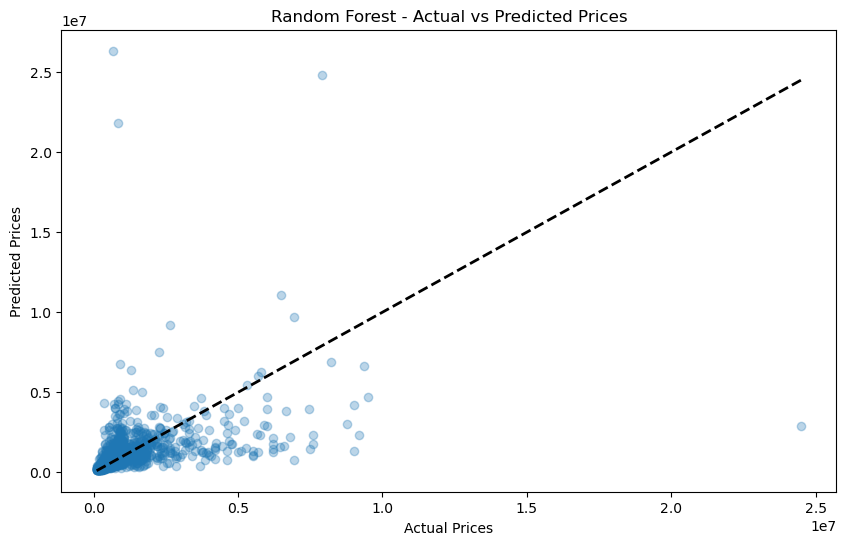

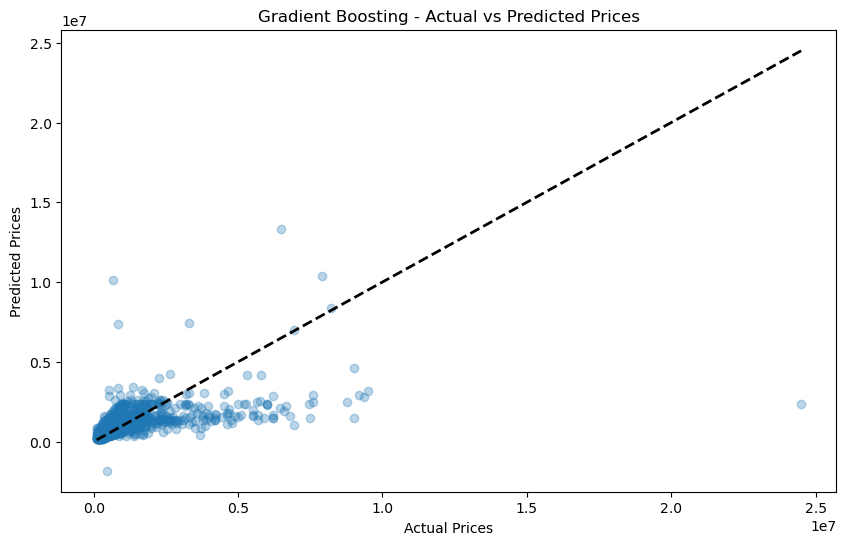

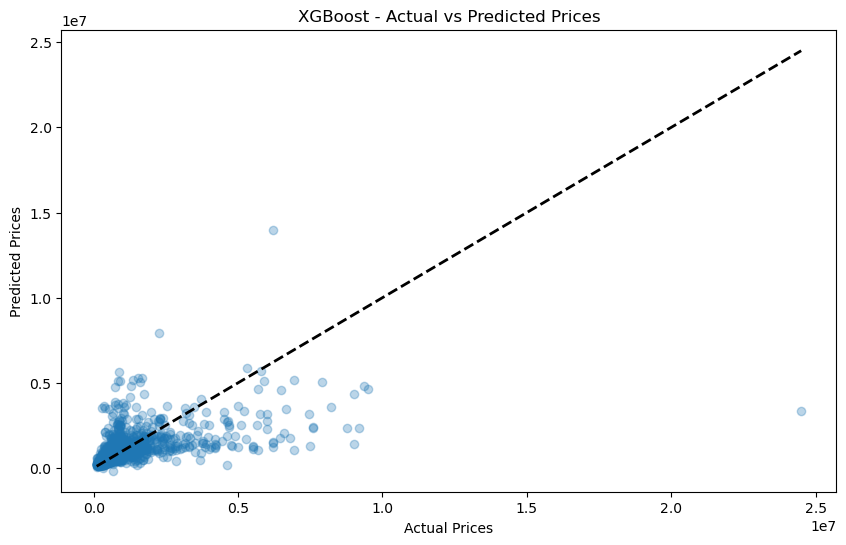

In [5]:
#Visualize Predictions vs. Actual Values
import matplotlib.pyplot as plt

# Function to plot predictions vs actual values
def plot_predictions_vs_actual(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'{model_name} - Actual vs Predicted Prices')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.show()

plot_predictions_vs_actual(y_test, y_pred, 'Random Forest')
plot_predictions_vs_actual(y_test, y_pred_gb, 'Gradient Boosting')
plot_predictions_vs_actual(y_test, y_pred_xg, 'XGBoost')


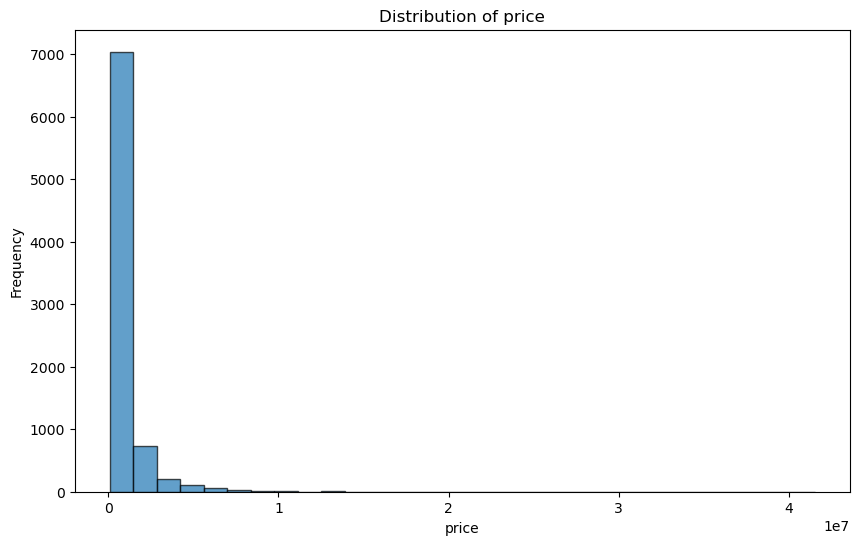

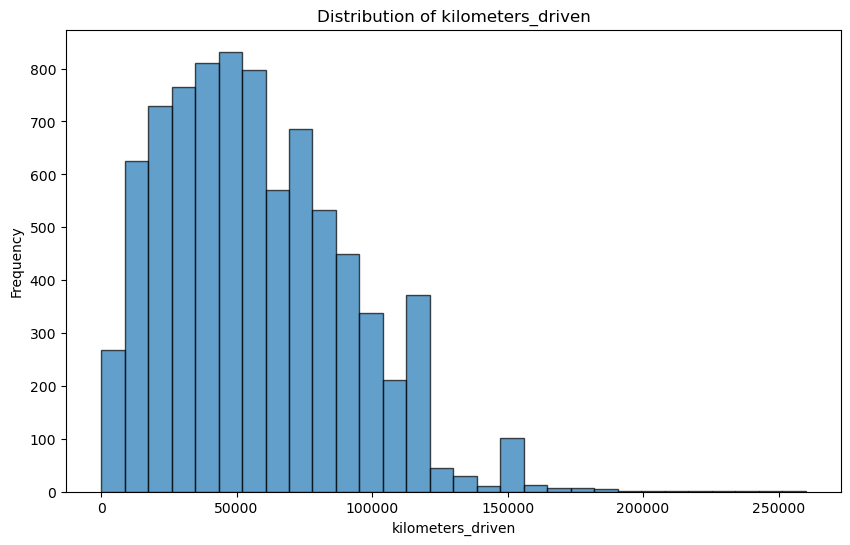

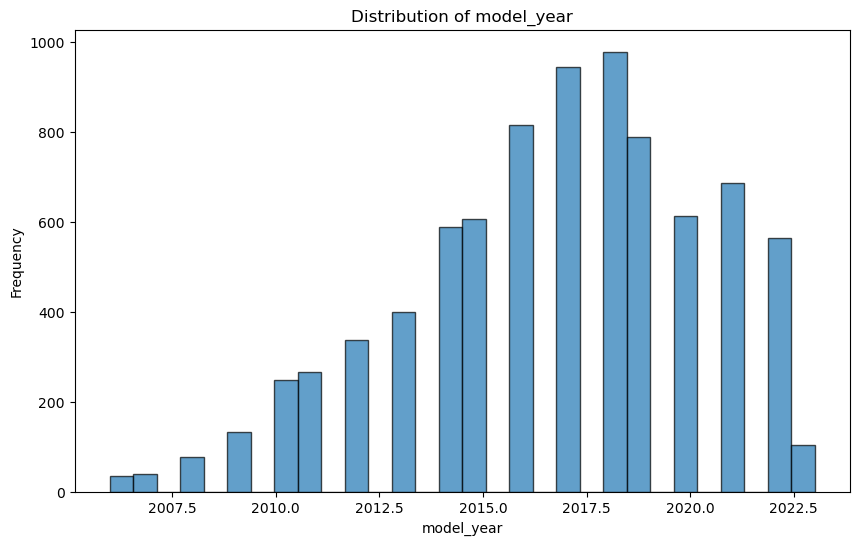

In [6]:
#Check Data Distribution
def check_distribution(df, column):
    plt.figure(figsize=(10, 6))
    plt.hist(df[column], bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

check_distribution(combined_df, 'price')
for feature in numeric_features:
    check_distribution(combined_df, feature)


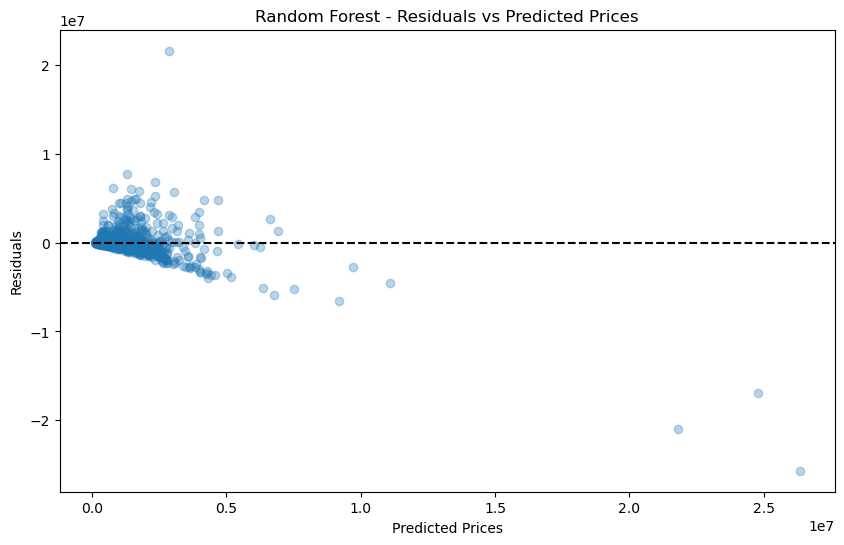

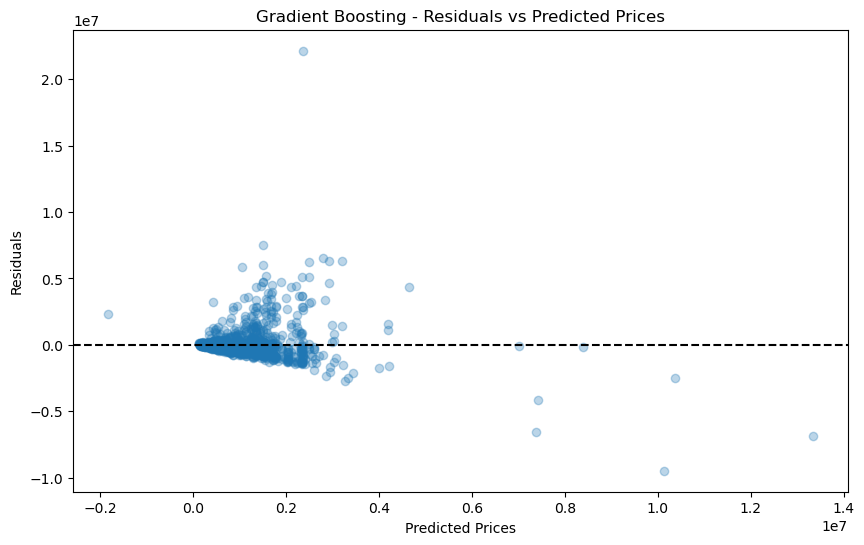

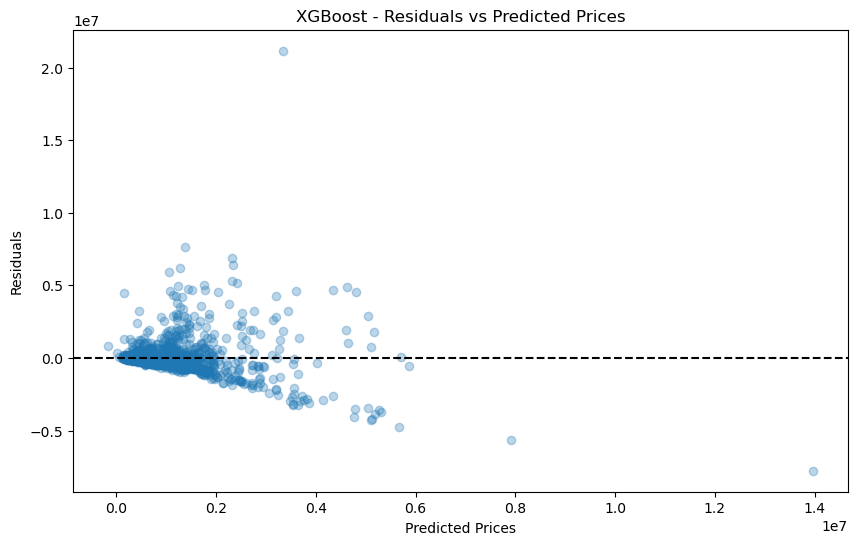

In [7]:
#Examine Residuals
# Function to plot residuals
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.3)
    plt.xlabel('Predicted Prices')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Residuals vs Predicted Prices')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.show()

plot_residuals(y_test, y_pred, 'Random Forest')
plot_residuals(y_test, y_pred_gb, 'Gradient Boosting')
plot_residuals(y_test, y_pred_xg, 'XGBoost')
